In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_path = "data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt"

df = pd.read_csv(data_path)
df["start_timestamp"] = df["end_timestamp"] - df["duration"]
df = df.sort_values(by="start_timestamp", ascending=True)
df["start_timestamp"] = pd.to_datetime(df["start_timestamp"], unit="s", origin=datetime.now())
df["duration"] = pd.to_timedelta(df["duration"], unit="s")
df = df.drop("app", axis=1).drop("end_timestamp", axis=1)
df.head()

,func,duration,start_timestamp
0,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0 days 00:00:00.078000,2025-03-21 16:40:08.001490831
1,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,0 days 00:00:57.154000,2025-03-21 16:40:08.003859997
2,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,0 days 00:00:59.125000,2025-03-21 16:40:08.005477905
3,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,0 days 00:00:06.236000,2025-03-21 16:40:08.016541004
4,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0 days 00:00:00.050000,2025-03-21 16:40:08.016824007


In [2]:
from simulator import ServerlessSimulator, Distribution

# Taken from measurements for simulator
warm_dist = Distribution([0.000017, 0.000015], [0.021617, 0.010093], [0.000007, 0.000005])
cold_dist = Distribution([1.121333, 0.629269], [0.220730, 0.045443], [0.000013, 0.000009])

func_name = df["func"].mode()[0]

In [14]:
sim = ServerlessSimulator(df, warm_dist, cold_dist,
                          default_min_num_containers=0,
                          default_warming_period=600,
                          predictor_interval=360,
                          predictor_history_interval=100000,
                          granularity=1
                        )

logs, containers = sim.run(func_name, 100000, with_model=True)

100%|██████████| 100000/100000 [12:23<00:00, 134.46it/s]


In [15]:
sim_no = ServerlessSimulator(df, warm_dist, cold_dist,
                          default_min_num_containers=0,
                          default_warming_period=600,
                          predictor_interval=360,
                          predictor_history_interval=100000,
                          granularity=1
                        )

logs_no, containers_no = sim_no.run(func_name, 100000, with_model=False)

100%|██████████| 100000/100000 [02:33<00:00, 653.49it/s]


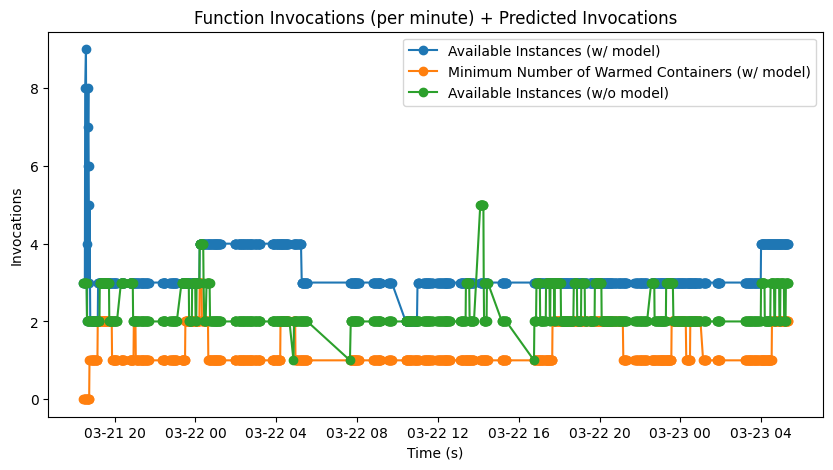

In [5]:
f = sim._functions[func_name]
f_no = sim_no._functions[func_name]

plt.figure(figsize=(10, 5))
plt.title("Function Invocations (per minute) + Predicted Invocations")
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
f.history["y_s"] = f.history["y"].rolling(window=10, min_periods=1).mean()
# plt.plot(f.history['ds'], f.history['y_s'], '-o', label="Actual Invocations")

plt.plot(f.history['ds'], f.history['available_containers'], '-o', label="Available Instances (w/ model)")
plt.plot(f.history['ds'], f.history['min_num_containers'], '-o', label="Minimum Number of Warmed Containers (w/ model)")
plt.plot(f_no.history['ds'], f_no.history['available_containers'], '-o', label="Available Instances (w/o model)")

# for pred in f.predictions:
#     plt.plot(pred['ds'], list(map(lambda x: 0 if x < 0 else x, pred['yhat'])), '-o', color="red", label="Predicted Invocations")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


Text(0.5, 1.0, 'Function Invocations w/ model')

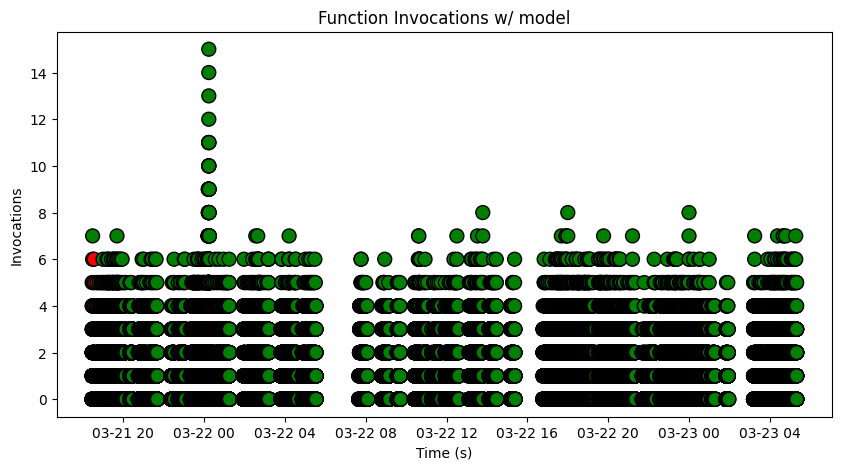

In [6]:
invoked_floor = pd.DataFrame(logs)
invoked_floor['ds'] = invoked_floor['ds'].dt.floor('s')
invoked_floor['y_jitter'] = invoked_floor.groupby('ds').cumcount()
invoked_floor['color'] = invoked_floor['is_warm_start'].map({False: 'red', True: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor['ds'], invoked_floor['y_jitter'], c=invoked_floor['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/ model')

Text(0.5, 1.0, 'Function Invocations w/o model')

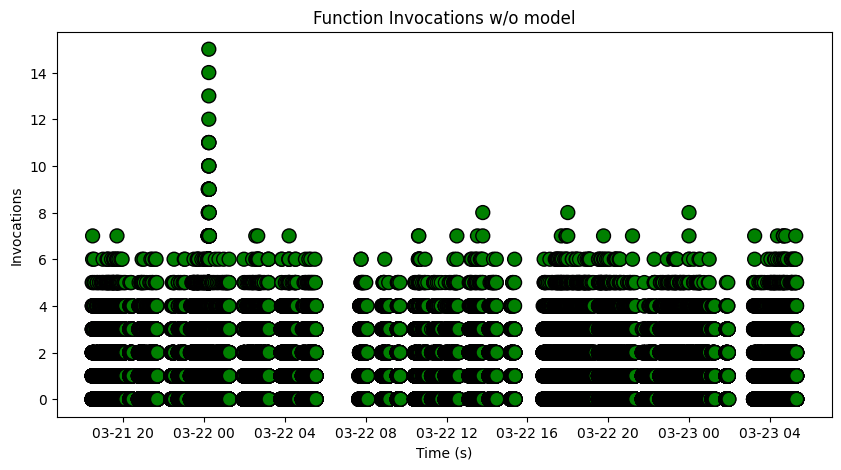

In [7]:
invoked_floor_no = pd.DataFrame(logs_no)
invoked_floor_no['ds'] = invoked_floor_no['ds'].dt.floor('s')
invoked_floor_no['y_jitter'] = invoked_floor_no.groupby('ds').cumcount()
invoked_floor_no['color'] = invoked_floor_no['is_warm_start'].map({False: 'red', True: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor_no['ds'], invoked_floor_no['y_jitter'], c=invoked_floor_no['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/o model')

In [8]:
print("Number of cold starts: " + str(len(list(filter(lambda x: not x, logs['is_warm_start'])))))
print("Number of warm starts: " + str(len(list(filter(lambda x: x, logs['is_warm_start'])))))

Number of cold starts: 518
Number of warm starts: 99482


In [9]:
print("Number of cold starts: " + str(len(list(filter(lambda x: not x, logs_no['is_warm_start'])))))
print("Number of warm starts: " + str(len(list(filter(lambda x: x, logs_no['is_warm_start'])))))

Number of cold starts: 75
Number of warm starts: 99925


In [10]:
containers['efficiency'] = (containers['active_time'] / (containers['expiration'] - containers['creation'])) * 100
containers_cleaned = containers.query("efficiency != 0 and efficiency == efficiency and efficiency != inf and efficiency != -inf")
containers_no['efficiency'] = (containers_no['active_time'] / (containers_no['expiration'] - containers_no['creation'])) * 100
containers_no_cleaned = containers_no.query("efficiency != 0 and efficiency == efficiency and efficiency != inf and efficiency != -inf")

In [11]:
containers_cleaned['efficiency'].mean()

np.float64(0.6672709887506194)

In [12]:
containers_no_cleaned['efficiency'].mean()

np.float64(0.701476090382014)

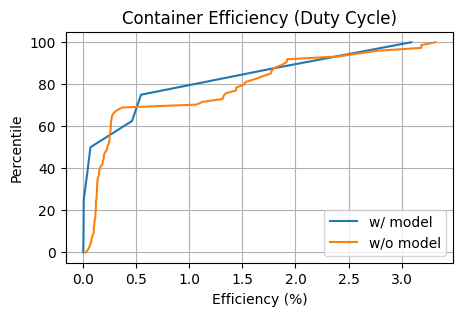

In [13]:
def percentile_plot(data, label):
    sorted_data = np.sort(data)
    percentiles = np.linspace(0, 100, len(sorted_data))
    plt.plot(sorted_data, percentiles, label=label)

plt.figure(figsize=(5, 3))
percentile_plot(containers_cleaned['efficiency'], "w/ model")
percentile_plot(containers_no_cleaned['efficiency'], "w/o model")

plt.xlabel("Efficiency (%)")
plt.ylabel("Percentile")
plt.title("Container Efficiency (Duty Cycle)")
plt.legend()
plt.grid()

plt.show()